In [1]:
# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utility
from google.colab import files
import warnings, re
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)


In [2]:
uploaded = files.upload()  # upload the Kaggle CSV you downloaded
csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)
print(csv_name, df.shape)
df.head()


Saving StudentPerformanceFactors.csv to StudentPerformanceFactors.csv
StudentPerformanceFactors.csv (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [7]:
expected_cols = [
    'Hours_Studied','Attendance','Parental_Involvement','Access_to_Resources',
    'Extracurricular_Activities','Sleep_Hours','Previous_Scores','Motivation_Level',
    'Internet_Access','Tutoring_Sessions','Family_Income','Teacher_Quality','School_Type',
    'Peer_Influence','Physical_Activity','Learning_Disabilities','Parental_Education_Level',
    'Distance_from_Home','Gender','Exam_Score'
]
print('Has expected columns:', set(expected_cols).issubset(df.columns))
print('Extra/missing:', set(df.columns)-set(expected_cols), set(expected_cols)-set(df.columns))
print('Rows, Cols:', df.shape)


Has expected columns: True
Extra/missing: set() set()
Rows, Cols: (6607, 20)


In [9]:
# Drop exact duplicates
before = len(df)
df = df.drop_duplicates().copy()
print(f"Duplicates removed: {before - len(df)}")

# Strip whitespace in string columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

# Handle missing values
numeric_cols_raw = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_raw = [c for c in df.columns if c not in numeric_cols_raw]

# Fill numeric with median, categorical with mode
for c in numeric_cols_raw:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols_raw:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode()[0])

# Light outlier capping on obvious continuous fields
caps = {
    'Hours_Studied': (0, 16),         # hours/day
    'Attendance': (0, 100),           # %
    'Sleep_Hours': (0, 14),           # hours/day
    'Previous_Scores': (0, 100),      # %
    'Tutoring_Sessions': (0, 10),     # /week
    'Physical_Activity': (0, 14),     # hours/week
    'Exam_Score': (0, 100)            # %
}

for col, (lo, hi) in caps.items():
    if col in df.columns:
        if lo is not None: df[col] = np.maximum(df[col], lo)
        if hi is not None: df[col] = np.minimum(df[col], hi)

df.head()

Duplicates removed: 0


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,16,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,16,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,16,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,16,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,16,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [10]:
# Common binary text fields to yes/no --- 1/0
yn_map = {'yes':1,'no':0,'y':1,'n':0,'true':1,'false':0,'1':1,'0':0}

def binarize(series):
    s = series.astype(str).str.lower().str.strip()
    return s.map(yn_map).fillna(series)  # if not yes/no, leave as-is

binary_like = ['Access_to_Resources','Extracurricular_Activities','Internet_Access','Learning_Disabilities']
for col in binary_like:
    if col in df.columns:
        df[col] = binarize(df[col])

# Standardize Gender to ['Male','Female'] if possible
if 'Gender' in df.columns:
    g = df['Gender'].astype(str).str.lower()
    df['Gender'] = np.where(g.str.contains('m'), 'Male',
                     np.where(g.str.contains('f'), 'Female', df['Gender']))

# School_Type examples: 'Public','Private' etc. (leave as-is for OHE)
# Parental_Education_Level: keep as category strings (e.g., 'High School','Graduate','Postgraduate')

In [14]:
fe = df.copy()

# (1) Study Efficiency: hours studied adjusted for attendance exposure
fe['Study_Efficiency'] = fe['Hours_Studied'] / (fe['Attendance'] / 100 + 0.01)

# (2) Attendance_Ratio: normalized attendance
fe['Attendance_Ratio'] = fe['Attendance'] / 100

# (3) Previous_Normalized: past performance on 0-1
fe['Previous_Normalized'] = fe['Previous_Scores'] / 100

# (4) Sleep_Quality_Score: ideal ~7-8 hrs -> bell-shaped score
fe['Sleep_Quality_Score'] = np.exp(-((fe['Sleep_Hours'] - 7.5) ** 2) / (2 * (1.5 ** 2)))

# (5) Activity_Index: combine extracurricular + physical activity
#     Extracurricular_Activities may be 0/1 or text -> already binarized above
eca = pd.to_numeric(fe['Extracurricular_Activities'], errors='coerce').fillna(0)
# Ensure the divisor for Physical_Activity is at least 1
physical_activity_max_normalized = np.maximum(fe['Physical_Activity'].max(), 1)
fe['Activity_Index'] = 0.6 * (eca) + 0.4 * (fe['Physical_Activity'] / physical_activity_max_normalized)

# (6) Resource_Index: Access + Internet + Tutoring (scaled)
acc = pd.to_numeric(fe['Access_to_Resources'], errors='coerce').fillna(0)
net = pd.to_numeric(fe['Internet_Access'], errors='coerce').fillna(0)
tut = fe['Tutoring_Sessions'].clip(lower=0)
fe['Resource_Index'] = 0.4*acc + 0.3*net + 0.3*(tut / (tut.max() if tut.max()>0 else 1))

# (7) Parental_Support_Index: Parental involvement + education proxy
edu_map = {
    'none':0,'illiterate':0,
    'primary':1,'middle':2,'high school':3,'higher secondary':4,
    'diploma':4,'undergraduate':5,'graduate':6,'bachelor':6,
    'postgraduate':7,'master':7,'phd':8,'doctorate':8
}
pei = fe['Parental_Education_Level'].astype(str).str.lower().map(edu_map).fillna(4)

# Convert Parental_Involvement to numeric before division
pi_map = {'Low': 1, 'Medium': 5, 'High': 10}
parental_involvement_numeric = fe['Parental_Involvement'].map(pi_map).fillna(5) # Default to Medium if unknown

fe['Parental_Support_Index'] = 0.7*(parental_involvement_numeric/10) + 0.3*(pei/8)

# (8) Teacher_Effect_Score: teacher quality + school type boost
stype = fe['School_Type'].astype(str).str.lower()
school_boost = np.where(stype.str.contains('private'), 0.05, 0.0)  # small assumed effect

# Convert Teacher_Quality to numeric before division
tq_map = {'Low': 1, 'Medium': 5, 'High': 10}
teacher_quality_numeric = fe['Teacher_Quality'].map(tq_map).fillna(5) # Default to Medium if unknown
fe['Teacher_Effect_Score'] = (teacher_quality_numeric/10) + school_boost

# (9) Peer_Pressure_Negative: invert peer influence if higher = worse
# Convert Peer_Influence to numeric before division
pinf_map = {'Negative': 1, 'Neutral': 5, 'Positive': 10}
peer_influence_numeric = fe['Peer_Influence'].map(pinf_map).fillna(5) # Default to Neutral if unknown
fe['Peer_Pressure_Negative'] = 1 - (peer_influence_numeric / 10)

# (10) Commute_Burden: scaled distance (higher = worse)
# Convert Distance_from_Home to numeric before operations
dist_map = {'Near': 1, 'Moderate': 5, 'Far': 10}
distance_from_home_numeric = fe['Distance_from_Home'].map(dist_map).fillna(5) # Default to Moderate if unknown
fe['Commute_Burden'] = (distance_from_home_numeric - distance_from_home_numeric.min()) / \
                       (distance_from_home_numeric.max() - distance_from_home_numeric.min() + 1e-9)

# (11) Wellness_Index: blend sleep, physical activity, motivation
# Convert Motivation_Level to numeric before division
mot_map = {'Low': 1, 'Medium': 5, 'High': 10}
motivation_level_numeric = fe['Motivation_Level'].map(mot_map).fillna(5) # Default to Medium if unknown
fe['Wellness_Index'] = 0.4*fe['Sleep_Quality_Score'] + \
                       0.3*(fe['Physical_Activity'] / physical_activity_max_normalized) + \
                       0.3*(motivation_level_numeric/10)

print('Engineered features added:', [c for c in fe.columns if c not in df.columns or c in [
    'Study_Efficiency','Attendance_Ratio','Previous_Normalized','Sleep_Quality_Score',
    'Activity_Index','Resource_Index','Parental_Support_Index','Teacher_Effect_Score',
    'Peer_Pressure_Negative','Commute_Burden','Wellness_Index'
]])

Engineered features added: ['Study_Efficiency', 'Attendance_Ratio', 'Previous_Normalized', 'Sleep_Quality_Score', 'Activity_Index', 'Resource_Index', 'Parental_Support_Index', 'Teacher_Effect_Score', 'Peer_Pressure_Negative', 'Commute_Burden', 'Wellness_Index']


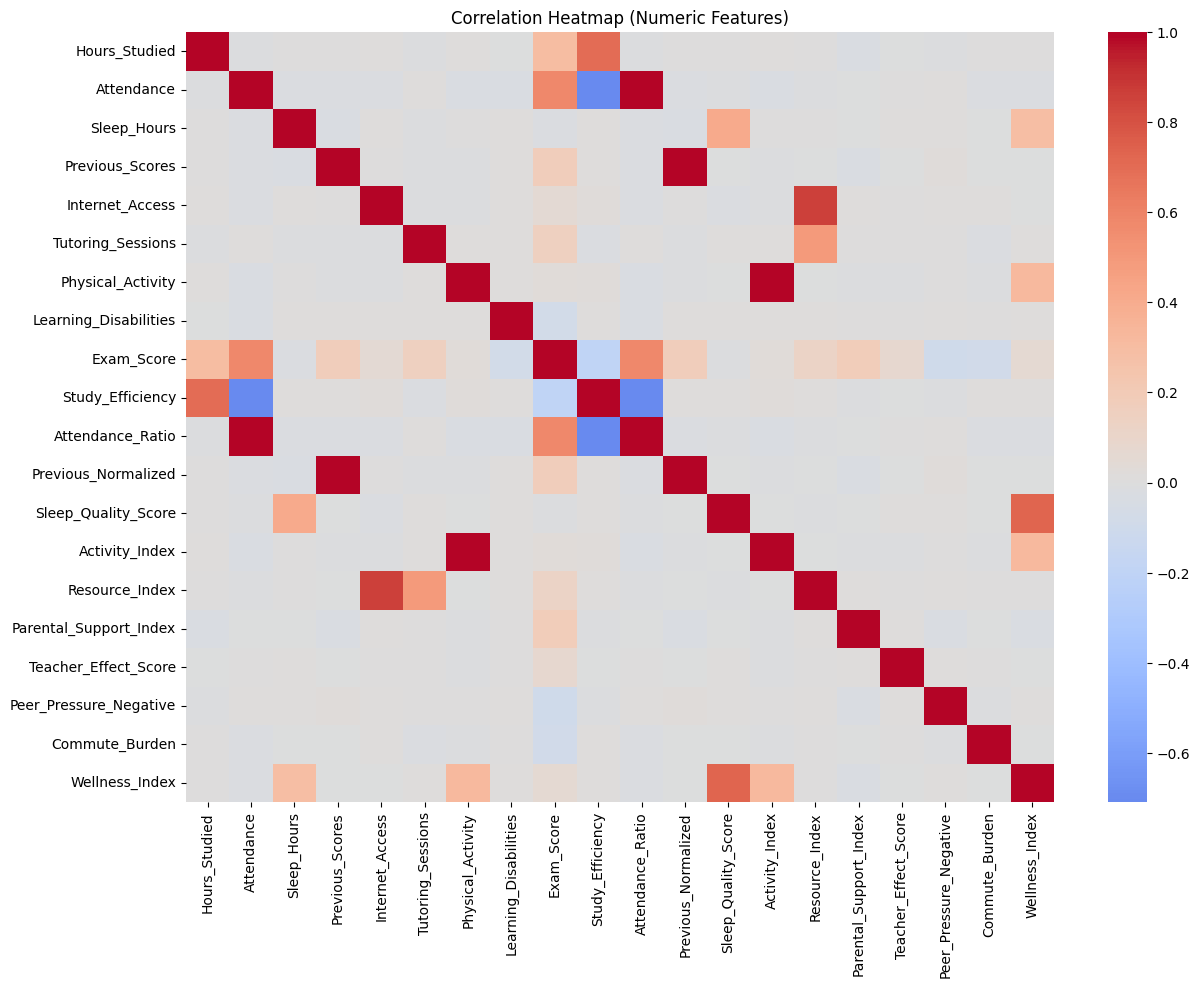

In [15]:
num_cols = fe.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(14,10))
sns.heatmap(fe[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


In [17]:
# Target
target = 'Exam_Score'

# Base + engineered features for modeling
feature_cols = [
    'Hours_Studied','Attendance','Parental_Involvement','Access_to_Resources',
    'Extracurricular_Activities','Sleep_Hours','Previous_Scores','Motivation_Level',
    'Internet_Access','Tutoring_Sessions','Family_Income','Teacher_Quality',
    'School_Type','Peer_Influence','Physical_Activity','Learning_Disabilities',
    'Parental_Education_Level','Distance_from_Home','Gender',
    # engineered
    'Study_Efficiency','Attendance_Ratio','Previous_Normalized','Sleep_Quality_Score',
    'Activity_Index','Resource_Index','Parental_Support_Index','Teacher_Effect_Score',
    'Peer_Pressure_Negative','Commute_Burden','Wellness_Index'
]

available = [c for c in feature_cols if c in fe.columns]
print(f"Using {len(available)} features.")

X = fe[available].copy()
y = fe[target].copy()

# Identify numeric vs categorical
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = [c for c in X.columns if c not in num_feats]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
    ]
)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('linreg', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# 5-fold CV R² for stability check
cv_r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
print("CV R² (mean ± std): {:.3f} ± {:.3f}".format(cv_r2.mean(), cv_r2.std()))

Using 30 features.
MAE  : 1.218
RMSE : 2.229
R²   : 0.649
CV R² (mean ± std): 0.617 ± 0.067


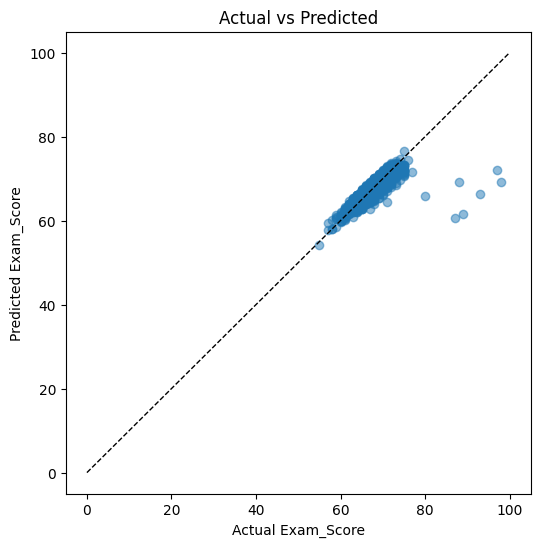

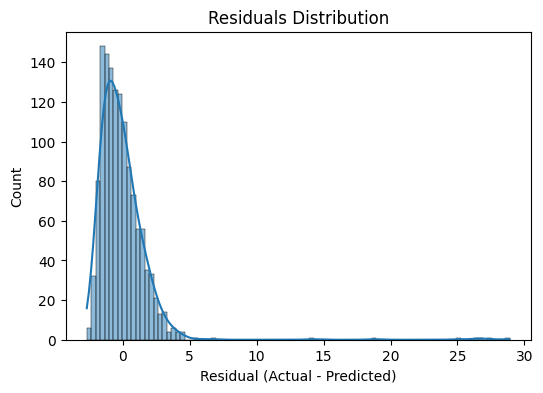

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Exam_Score')
plt.ylabel('Predicted Exam_Score')
plt.title('Actual vs Predicted')
plt.plot([0,100],[0,100], 'k--', linewidth=1)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


In [19]:
# Extract feature names after OHE + scaling
ohe = pipe.named_steps['prep'].named_transformers_['cat']
ohe_features = []
if len(cat_feats) > 0:
    ohe_features = ohe.get_feature_names_out(cat_feats).tolist()

final_feature_names = num_feats + ohe_features

coef = pipe.named_steps['linreg'].coef_.ravel()
coef_df = pd.DataFrame({'feature': final_feature_names, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False).head(20)


,feature,coef,abs_coef
0,Hours_Studied,1.482519,1.482519
22,Access_to_Resources_High,1.062204,1.062204
23,Access_to_Resources_Low,-1.039524,1.039524
9,Attendance_Ratio,0.999397,0.999397
1,Attendance,0.999397,0.999397
14,Parental_Support_Index,0.618254,0.618254
30,Family_Income_High,0.505684,0.505684
5,Tutoring_Sessions,0.487789,0.487789
31,Family_Income_Low,-0.469499,0.469499
8,Study_Efficiency,-0.393203,0.393203


In [21]:
fe['Predicted_Exam_Score'] = pipe.predict(X)
# You can tweak threshold: e.g., < 40 is high risk, 40-60 is moderate
fe['Risk_Level'] = np.where(fe['Predicted_Exam_Score'] < 40, 'High',
                     np.where(fe['Predicted_Exam_Score'] < 60, 'Moderate', 'Low'))

risk_summary = fe['Risk_Level'].value_counts()
print(risk_summary)

at_risk_df = fe.loc[fe['Risk_Level'].isin(['High','Moderate']),
                    ['Predicted_Exam_Score','Risk_Level','Hours_Studied','Attendance',
                     'Previous_Scores','Parental_Involvement','Motivation_Level',
                     'Access_to_Resources','Internet_Access','Tutoring_Sessions',
                     'Teacher_Quality','Peer_Influence','Sleep_Hours','Distance_from_Home']].sort_values('Predicted_Exam_Score')

at_risk_df.head(15)

Risk_Level
Low         6543
Moderate      64
Name: count, dtype: int64


,Predicted_Exam_Score,Risk_Level,Hours_Studied,Attendance,Previous_Scores,Parental_Involvement,Motivation_Level,Access_to_Resources,Internet_Access,Tutoring_Sessions,Teacher_Quality,Peer_Influence,Sleep_Hours,Distance_from_Home
1101,54.068736,Moderate,3,62,67,Medium,Medium,Low,1,1,Medium,Negative,6,Near
5507,55.880403,Moderate,5,65,71,Low,Medium,High,1,0,Medium,Negative,7,Far
2947,55.923852,Moderate,2,67,73,Medium,Low,Medium,1,1,Medium,Positive,6,Moderate
5907,55.946738,Moderate,3,60,78,Medium,Low,Low,1,1,Medium,Positive,6,Near
4639,56.383988,Moderate,3,70,58,Medium,Medium,Medium,1,0,Medium,Neutral,7,Moderate
4635,56.481721,Moderate,3,60,76,Medium,Medium,Medium,1,0,High,Neutral,5,Moderate
668,56.702940,Moderate,4,69,93,Medium,Low,Low,0,2,High,Negative,9,Moderate
6431,57.042416,Moderate,4,60,55,Medium,Medium,Medium,1,2,Medium,Neutral,7,Near
4033,57.159470,Moderate,3,79,64,Low,Low,Medium,1,0,Medium,Negative,7,Far
2880,57.328652,Moderate,7,66,68,High,High,Low,1,0,Medium,Negative,8,Moderate


In [22]:
# Save at-risk list
out_name = 'at_risk_students.csv'
fe[['Predicted_Exam_Score','Risk_Level']].join(df[['Hours_Studied','Attendance','Previous_Scores']]).to_csv(out_name, index=False)
print('Saved:', out_name)


Saved: at_risk_students.csv


In [23]:
X_train, X_test, y_train, y_test


(      Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
 5810             16          79                  Low                High   
 1268             16          86                 High              Medium   
 414              16          87                  Low              Medium   
 4745             16         100                 High              Medium   
 654              16          78                 High                 Low   
 ...             ...         ...                  ...                 ...   
 3772             15          82               Medium              Medium   
 5191             16          65               Medium              Medium   
 5226             16          64                 High                 Low   
 5390             16         100                 High                High   
 860              16          62               Medium                 Low   
 
      Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
 5810   

In [24]:
!pip install xgboost catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.0 MB/s eta 0:00:00


In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import time


In [26]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "SVR": SVR(kernel='rbf', C=10, gamma='scale'),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, eval_metric='rmse',
        tree_method='hist'
    ),
    "CatBoost": CatBoostRegressor(
        iterations=300, learning_rate=0.05, depth=6, verbose=0
    )
}


In [28]:
results = []

for name, model_algo in models.items():
    print(f"Training {name}...")

    model = Pipeline(steps=[
        ('prep', preprocess),   # << your scaling + OHE pipeline
        ('model', model_algo)
    ])

    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred) # Calculate MSE first
    rmse = np.sqrt(mse) # Then take square root for RMSE
    r2 = r2_score(y_test, y_pred)

    results.append([name, r2, rmse, mae, end - start])

Training LinearRegression...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training DecisionTree...
Training RandomForest...
Training ExtraTrees...
Training GradientBoosting...
Training KNN...
Training SVR...
Training XGBoost...
Training CatBoost...


In [29]:
results_df = pd.DataFrame(results,
                          columns=['Model', 'R2 Score', 'RMSE', 'MAE', 'Time Taken (sec)'])

results_df = results_df.sort_values(by='R2 Score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,R2 Score,RMSE,MAE,Time Taken (sec)
0,CatBoost,0.659368,2.194278,1.137822,1.351256
1,Lasso,0.648768,2.228158,1.216716,0.391564
2,ElasticNet,0.648691,2.228403,1.217140,0.285380
3,Ridge,0.648553,2.228841,1.217807,0.128437
4,LinearRegression,0.648536,2.228893,1.217880,0.221142
5,GradientBoosting,0.641537,2.250976,1.227196,1.443474
6,SVR,0.629818,2.287476,1.232376,5.755636
7,XGBoost,0.616921,2.326983,1.277447,0.655739
8,RandomForest,0.597720,2.384586,1.379763,21.449473
9,ExtraTrees,0.581705,2.431589,1.409597,18.182902
